#  Masking Pipeline

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)


In [21]:
from chxanalys.chx_libs import (np, roi, time, datetime, os,  getpass, db, get_images,LogNorm, plt,ManualMask)
from chxanalys.chx_libs import cmap_albula, cmap_vge, random
from chxanalys.chx_generic_functions import (get_detector, get_meta_data,create_user_folder,
                                             get_fields,  get_sid_filenames,load_data,
                                             RemoveHot, show_img,get_avg_img, 
                                             reverse_updown,create_cross_mask,mask_badpixels )
from skimage.draw import line_aa, line, polygon, circle
 
%matplotlib notebook

# Path for Saving Results

In [7]:
CYCLE= '2017_2'  #change clycle here

In [8]:
path = '/XF11ID/analysis/%s/masks/'%CYCLE
print ("The analysis results will be saved in : %s"%path)

The analysis results will be saved in : /XF11ID/analysis/2017_2/masks/


### Get the image series and metadata from the uid

In [9]:
 

uid = '8bd04b' # (scan num: 22932) (Measurement: single frame 0.3 deg for mask )
uid = 'acac04' # (scan num: 23612) (Measurement: CoralPor for mask )
uid = 'c2afee' # (scan num: 23614) (Measurement: CoralPor for mask_new )
uid = 'e75486' # ] (scan num: 23675) (Measurement: 5 CoralPor images - make mask )

uid = 'ebb2b9' #ct : 1 ['ebb2b9'] (scan num: 23708) (Measurement: Single frame for masking )


In [10]:
#%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/chx_generic_functions.py

In [11]:
md = get_meta_data( uid )
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])

print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  23708--ebb2b975-6ddf-4105-a30b-9f48730fb4f8--/XF11ID/data/2017/06/16/0b6306ac-4341-4993-ab83_1111


In [12]:
print(md['beam_center_y'], md['beam_center_x'])

1468.0 1361.0


In [13]:
imgs = load_data( uid, detector, reverse= False  )
#imgs = load_data( uid, detector, reverse= True  )
md.update( imgs.md );Nimg = len(imgs);
#if 'number of images'  not in list(md.keys()):
md['number of images']  = Nimg
pixel_mask =  1- np.int_( np.array( imgs.md['pixel_mask'], dtype= bool)  )
print( 'The data are: %s' %imgs )

The data are: <Frames>
Length: 1 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint32


In [15]:
pixel_mask =  1- np.int_( np.array( md['pixel_mask'], dtype= bool)  )

In [16]:
img_choice_N = 1  #can change this number to select more frames for average
img_samp_index = random.sample( range(len(imgs)), img_choice_N) 
avg_img =  get_avg_img( imgs, img_samp_index, plot_ = False, uid = uid)

## show image and the pixel mask

* show image

<IPython.core.display.Javascript object>


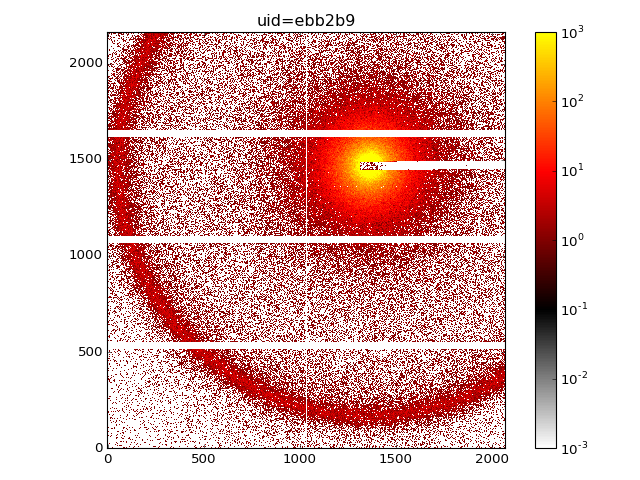

In [17]:
show_img(  avg_img*pixel_mask , vmin=.001, vmax=1e3, logs=True, 
         image_name ='uid=%s'%uid, aspect=1, cmap= cmap_albula  )


* pixel mask

### Update Pixel Mask due to bad pixel of Eiger Detector

In [22]:
pixel_mask = mask_badpixels( pixel_mask, md['detector'])

<IPython.core.display.Javascript object>


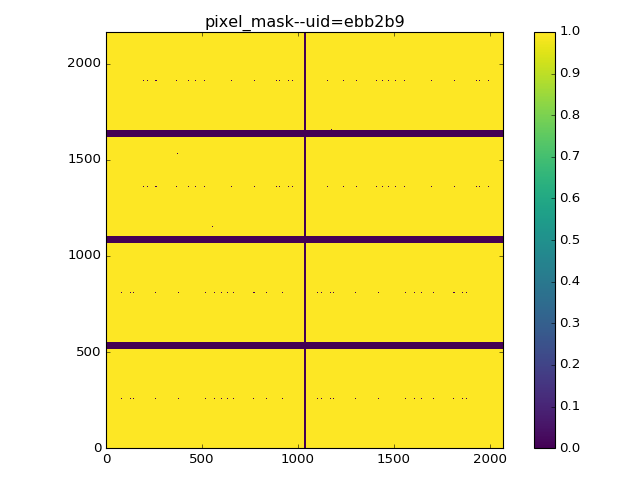

In [23]:
show_img( pixel_mask, vmin=0, vmax=1, image_name ='pixel_mask--uid=%s'%uid ,aspect=1 )

## Remove hotspots in the image

In [24]:
#avg_img =  get_avg_img( imgs, sampling = 1000, plot_ = False, uid =uid)

<IPython.core.display.Javascript object>


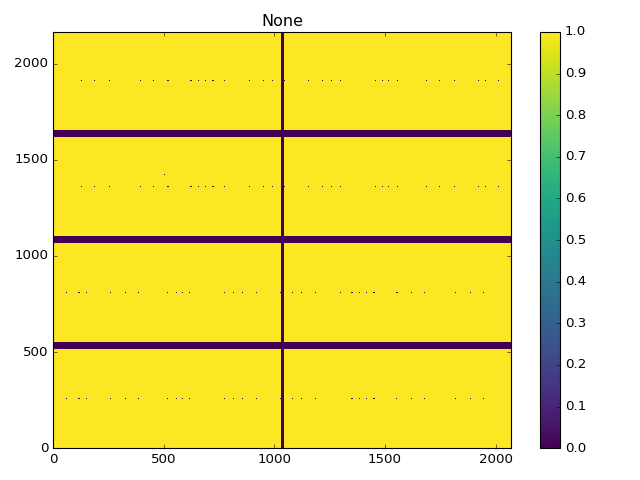

In [25]:
mask_rh  = RemoveHot( avg_img, 2**16-1, plot_=True)

<IPython.core.display.Javascript object>


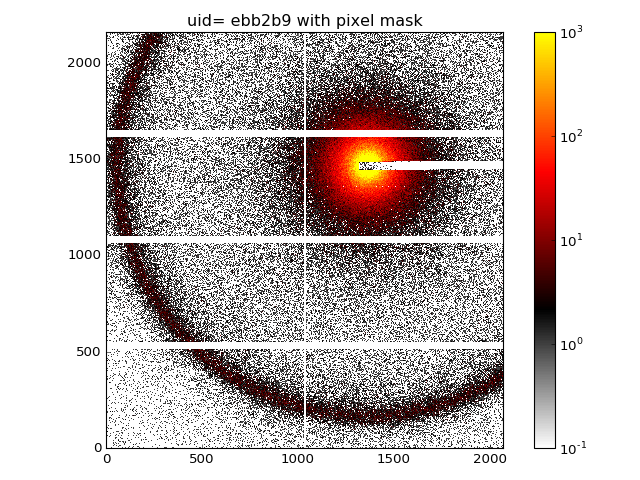

In [26]:
show_img(avg_img*pixel_mask,vmin=0.1,vmax=1e3, logs=True, 
         image_name= 'uid= %s with pixel mask'%uid , aspect=1, cmap= cmap_albula  )

# Create a polygon mask

* check beam center

In [27]:
#md['beam_center_x']= 1422
#md['beam_center_y']= 1439
#md['beam_center_x'],2167-md['beam_center_y']

In [28]:
md['beam_center_x'], md['beam_center_y']

(1361.0, 1468.0)

In [29]:
#md['beam_center_x'] = 1080
#md['beam_center_y'] = 1127

### To create multi-rectangle masks, for each sub-mask



In [30]:
#creat the right part mask
partial_mask = create_cross_mask(  avg_img, center=[1290,1469],
                            wy_left= 0, wy_right= 30, 
                              wx_up= 0, wx_down= 0,center_radius= 0 )

<IPython.core.display.Javascript object>


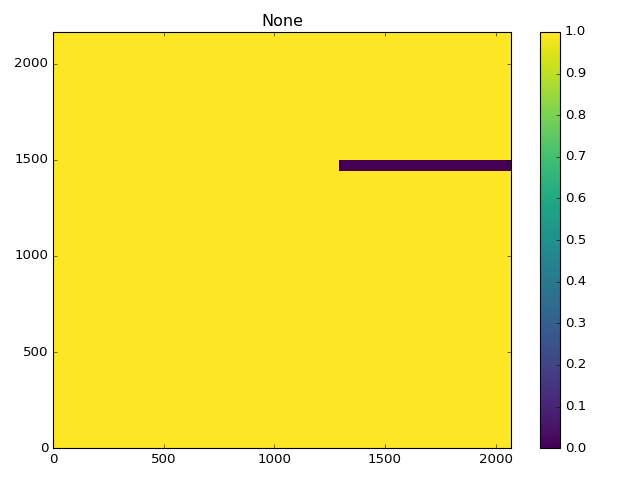

In [31]:
show_img(  partial_mask   )

In [32]:
avg_img.shape

(2167, 2070)

In [33]:
#creat the left/right/up/down part mask
partial_mask *=  create_cross_mask(  avg_img, center=[ 1422,1439],
                            wy_left= 0, wy_right= 0, 
                              wx_up= 0, wx_down=0,center_radius= 0 )
#partial_mask2[1285:1350,1430:1440,] = False

<IPython.core.display.Javascript object>


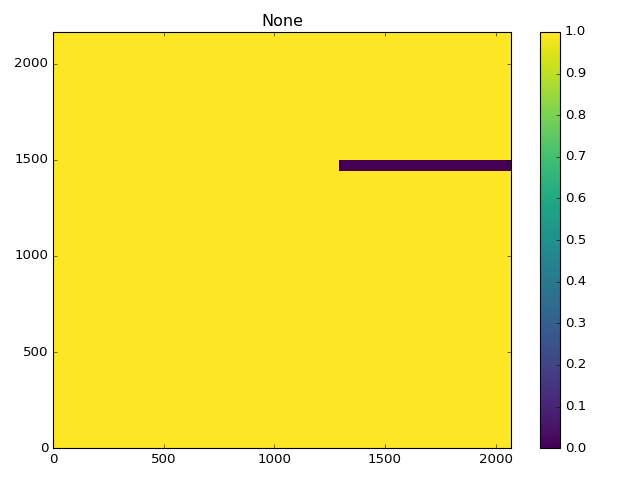

In [34]:
show_img(  partial_mask   )

In [39]:
#creat the left/right/up/down part mask
partial_mask *=  create_cross_mask(  avg_img, center=[ 982, 2100],
                            wy_left= 0, wy_right= 0, 
                              wx_up= 0, wx_down= 0,center_radius= 0 )


In [40]:
#create a circle mask for windows
if False: #make it True to make window mask
    window_shadow  = ~create_cross_mask(  avg_img, center=[ 911,997],
                           wy_left= 0, wy_right= 0, 
                             wx_up= 0, wx_down= 0,center_circle=True, center_radius= 680)
else:
    window_shadow = 1

In [41]:
full_mask = partial_mask *window_shadow

<IPython.core.display.Javascript object>


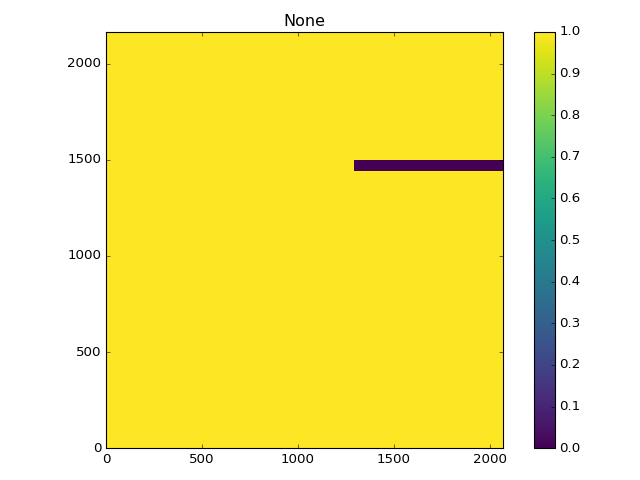

In [42]:
show_img( full_mask, aspect = 1 )

In [50]:
#mask = np.array ( full_mask * pixel_mask*mask_rh  , dtype = bool )
mask = np.array ( full_mask * pixel_mask , dtype = bool )

<IPython.core.display.Javascript object>


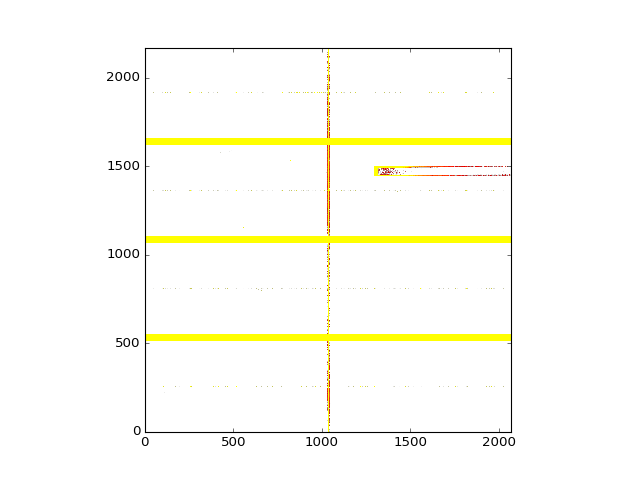

In [51]:
fig, ax = plt.subplots()
#new_mask = 
im=ax.imshow(   (~mask) * avg_img,origin='lower' , 
      norm= LogNorm( vmin=0.001, vmax= 1e2 ), cmap= cmap_albula)
#im = ax.imshow(avg_img,  cmap='viridis',origin='lower', norm= LogNorm( vmin=0.001, vmax=100 ) )
plt.show()


<IPython.core.display.Javascript object>


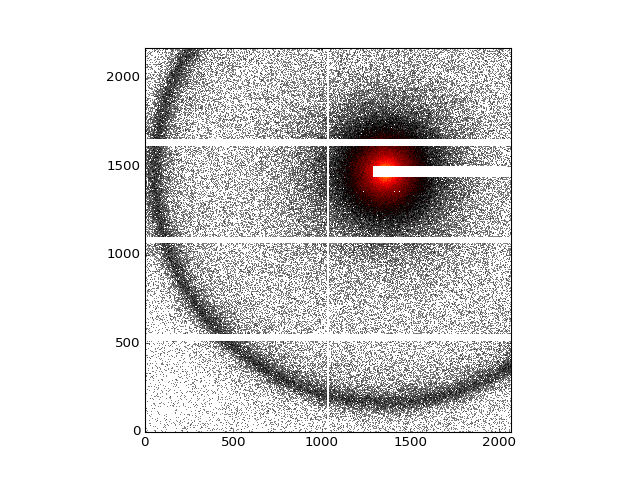

In [52]:
fig, ax = plt.subplots()
im = ax.imshow((mask)*avg_img,  cmap= cmap_albula,origin='lower',norm= LogNorm( vmin=.1, vmax=1e5 ),
               interpolation='none')
plt.show()

## Combine the hand-drawn/polygon mask and the pixel mask and hot pixel mask

<IPython.core.display.Javascript object>


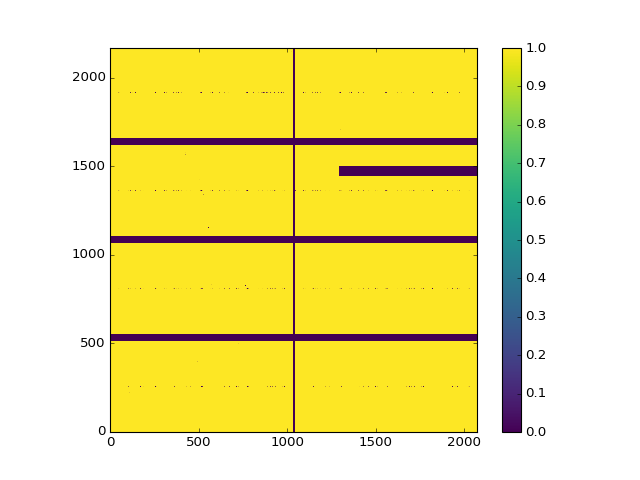

In [53]:
#mask = np.array ( ~new_mask* ~plgon_mask * md['pixel_mask']*mask_rh, dtype = bool )

fig, ax = plt.subplots()
im=ax.imshow(mask, origin='lower' ,vmin=0, vmax=1,cmap='viridis')
fig.colorbar(im)
plt.show()

## Save the combined mask to use in further data analysis

In [54]:
np.save(  path +   uid +"_mask", mask)

In [55]:
path +   uid +"_mask"

'/XF11ID/analysis/2017_2/masks/ebb2b9_mask'

In [56]:
meaningful_name = 'Jun16_SAXS_10m' 

In [60]:
#np.save(  path +   meaningful_name, mask)

In [58]:
path +   meaningful_name

'/XF11ID/analysis/2017_2/masks/Jun16_SAXS_10m'

In [59]:
uid

'ebb2b9'